<a href="https://colab.research.google.com/github/ricardodeazambuja/Maple-Syrup-Pi-Camera/blob/main/Model_Maker_Object_Detection_Tutorial_detect_heads_using_Open_Images_modified_for_Maple_Syrup_Pi_Camera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

######  Modified by [ricardodeazambuja.com](https://ricardodeazambuja.com)

# Object Detection with TensorFlow Lite Model Maker - Modified!

In the [previous notebook](https://github.com/ricardodeazambuja/Maple-Syrup-Pi-Camera/blob/main/Model_Maker_Object_Detection_Tutorial_modified_for_Maple_Syrup_Pi_Camera.ipynb), you learned how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) library to train a custom object detection model capable of detecting RPI Zero W within images on any device that can run TFLite models. The images were collected directly using Google Image Search, and annotated using the [VGG VIA Annotator](https://www.robots.ox.ac.uk/~vgg/software/via/via.html).

This time, instead of using Google Image Search, we will not annotate anything because we will directly use the [Open Images dataset](https://storage.googleapis.com/openimages/web/index.html).

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.

## Prerequisites


### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [ ]:
!pip install -q tflite-model-maker
!pip install -q pycocotools

We will need colab_utils to convert the dataset, augment and split into TRAIN, VALIDATION and TEST.

In [2]:
!pip install -q git+https://github.com/ricardodeazambuja/colab_utils.git

Let's install some tools to help us play with the [Open Images dataset](https://storage.googleapis.com/openimages/web/index.html). The tools can be found in [my fork of the Open Images repository](https://github.com/ricardodeazambuja/openimages).

In [ ]:
!wget -nc -q https://raw.githubusercontent.com/ricardodeazambuja/openimages/main/downloader.py
!wget -nc -q https://raw.githubusercontent.com/ricardodeazambuja/openimages/main/bbox_utils.py
!pip install -q boto3

Import the required packages.

In [4]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
from colab_utils import *

### Prepare the dataset using Open Images


We want to study how people move around a certain place (e.g. movement patterns so we can optimize the layout for social distancing). For that reason, we will create an object detector that detects human heads.

In [6]:
from bbox_utils import bboxUtils

bu = bboxUtils()

class-descriptions-boxable.csv saved!
bbox_labels_600_hierarchy.json saved!
oidv6-relationship-triplets.csv saved!


First we check if there's such a label:

In [7]:
bu.search_by_name("head")

,Code,Label
45,/m/01b7fy,Headphones
291,/m/04hgtk,Human head


Now we get the bboxes for training:

In [8]:
bboxes_train_all = bu.get_bboxes("train", ['/m/04hgtk'])
bboxes_train_all

oidv6-train-annotations-bbox.csv saved!
Searching for ['/m/04hgtk']...


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000004f4400f6ec5,xclick,/m/04hgtk,1,0.300625,0.508125,0.224090,0.608777,1,0,...,0,0,0.400625,0.432500,0.300625,0.508125,0.224090,0.608777,0.398693,0.409897
1,000004f4400f6ec5,xclick,/m/04hgtk,1,0.544375,0.692500,0.179272,0.469655,0,0,...,0,0,0.633125,0.544375,0.648750,0.692500,0.179272,0.323996,0.469655,0.275444
2,000004f4400f6ec5,xclick,/m/04hgtk,1,0.768125,0.999375,0.648926,0.999066,0,1,...,0,0,0.888750,0.911875,0.768125,0.999375,0.648926,0.999066,0.887021,0.874883
3,000018acd19b4ad3,xclick,/m/04hgtk,1,0.571289,0.740234,0.171303,0.428990,0,0,...,1,0,0.643555,0.642578,0.740234,0.571289,0.171303,0.428990,0.253294,0.269400
4,0000271195f2c007,xclick,/m/04hgtk,1,0.295312,0.690625,0.195833,0.929167,1,0,...,0,0,0.590625,0.495312,0.295312,0.690625,0.195833,0.929167,0.612500,0.383333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201628,fff11185281facb4,activemil,/m/04hgtk,1,0.365962,0.850945,0.168125,0.502500,1,0,...,1,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
201629,fff68132a193d8b3,activemil,/m/04hgtk,1,0.081633,0.863520,0.000000,0.946316,1,0,...,1,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
201630,fff7c7593ded46c6,activemil,/m/04hgtk,1,0.189283,0.392394,0.056875,0.225000,1,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
201631,fffc367ed76f4765,activemil,/m/04hgtk,1,0.157500,0.533333,0.050000,0.333750,1,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


And we filter to keep only photographs of real heads, not occluded or truncated, and definitely not from the inside:

In [9]:
bboxes_train = bboxes_train_all.loc[(bboxes_train_all['IsOccluded']=='0') & (bboxes_train_all['IsTruncated']=='0') & (bboxes_train_all['IsDepiction']=='0') & (bboxes_train_all['IsInside']=='0')]
bboxes_train

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
1,000004f4400f6ec5,xclick,/m/04hgtk,1,0.544375,0.692500,0.179272,0.469655,0,0,...,0,0,0.633125,0.544375,0.648750,0.692500,0.179272,0.323996,0.469655,0.275444
6,000033469fb48bc1,xclick,/m/04hgtk,1,0.393750,0.504375,0.121127,0.341784,0,0,...,0,0,0.436250,0.393750,0.504375,0.443750,0.121127,0.240376,0.217840,0.341784
7,000033469fb48bc1,xclick,/m/04hgtk,1,0.620000,0.720000,0.158685,0.349296,0,0,...,0,0,0.660625,0.639375,0.620000,0.720000,0.158685,0.349296,0.292958,0.221596
11,00006c07d2b033d1,xclick,/m/04hgtk,1,0.568750,0.750000,0.167187,0.406250,0,0,...,0,0,0.682813,0.568750,0.665625,0.750000,0.167187,0.295312,0.406250,0.298438
19,0000b86e2fd18333,xclick,/m/04hgtk,1,0.156250,0.461875,0.014815,0.562037,0,0,...,0,0,0.250625,0.461875,0.345625,0.156250,0.014815,0.252778,0.562037,0.241667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201605,ffe7b763894358f6,activemil,/m/04hgtk,1,0.337500,0.676562,0.032812,0.410937,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
201611,ffec27d7bedba653,activemil,/m/04hgtk,1,0.375000,0.737305,0.299559,0.825257,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
201622,ffecfc2b90b30243,xclick,/m/04hgtk,1,0.475000,0.552500,0.389167,0.525000,0,0,...,0,0,0.515000,0.525625,0.475000,0.552500,0.389167,0.525000,0.440833,0.463333
201623,ffecfc2b90b30243,xclick,/m/04hgtk,1,0.562500,0.643125,0.370000,0.504167,0,0,...,0,0,0.597500,0.613125,0.562500,0.643125,0.370000,0.504167,0.434167,0.430833


Before downloading the images, we want to make sure we have a list with unique file names

In [10]:
img_ids_train = bu.get_unique_img_ids(bboxes_train)
img_ids_train.shape[0]

24097

For this example we want to use a maximum of 500 images for training

In [11]:
# Download images matching ImageIDs from "train" set to to directory "imgs"
n_train_imgs = 500
bu.get_images(img_ids_train[:n_train_imgs], "train", "imgs", num_processes=5)

In [12]:
# Confirming the images are where we expect...
!ls -lah imgs | head

total 135M
drwxr-xr-x 2 root root  20K Oct 25 21:14 .
drwxr-xr-x 1 root root 4.0K Oct 25 21:14 ..
-rw-r--r-- 1 root root 316K Oct 25 21:14 000004f4400f6ec5.jpg
-rw-r--r-- 1 root root 159K Oct 25 21:14 000033469fb48bc1.jpg
-rw-r--r-- 1 root root 154K Oct 25 21:14 00006c07d2b033d1.jpg
-rw-r--r-- 1 root root 508K Oct 25 21:14 0000b86e2fd18333.jpg
-rw-r--r-- 1 root root  81K Oct 25 21:14 0000bee39176697a.jpg
-rw-r--r-- 1 root root  62K Oct 25 21:14 0000d01325742829.jpg
-rw-r--r-- 1 root root 239K Oct 25 21:14 0000ee1cc1f4c792.jpg


Filter the pandas dataframe to keep only the examples using the images we downloaded

In [13]:
bboxes_train_small = bboxes_train.loc[bboxes_train['ImageID'].isin(img_ids_train[:n_train_imgs])].copy()
bboxes_train_small

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
1,000004f4400f6ec5,xclick,/m/04hgtk,1,0.544375,0.692500,0.179272,0.469655,0,0,...,0,0,0.633125,0.544375,0.648750,0.692500,0.179272,0.323996,0.469655,0.275444
6,000033469fb48bc1,xclick,/m/04hgtk,1,0.393750,0.504375,0.121127,0.341784,0,0,...,0,0,0.436250,0.393750,0.504375,0.443750,0.121127,0.240376,0.217840,0.341784
7,000033469fb48bc1,xclick,/m/04hgtk,1,0.620000,0.720000,0.158685,0.349296,0,0,...,0,0,0.660625,0.639375,0.620000,0.720000,0.158685,0.349296,0.292958,0.221596
11,00006c07d2b033d1,xclick,/m/04hgtk,1,0.568750,0.750000,0.167187,0.406250,0,0,...,0,0,0.682813,0.568750,0.665625,0.750000,0.167187,0.295312,0.406250,0.298438
19,0000b86e2fd18333,xclick,/m/04hgtk,1,0.156250,0.461875,0.014815,0.562037,0,0,...,0,0,0.250625,0.461875,0.345625,0.156250,0.014815,0.252778,0.562037,0.241667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4084,038fe752ed842b9c,xclick,/m/04hgtk,1,0.097561,0.179174,0.207500,0.277500,0,0,...,0,0,0.138837,0.179174,0.128518,0.097561,0.207500,0.245000,0.277500,0.248125
4085,038fe752ed842b9c,xclick,/m/04hgtk,1,0.100375,0.158537,0.072500,0.116875,0,0,...,0,0,0.125704,0.100375,0.130394,0.158537,0.072500,0.094375,0.116875,0.093125
4086,038fe752ed842b9c,xclick,/m/04hgtk,1,0.310507,0.379925,0.035000,0.089375,0,0,...,0,0,0.348968,0.310507,0.335835,0.379925,0.035000,0.058750,0.089375,0.065625
4094,0392ed8f267219a6,xclick,/m/04hgtk,1,0.010937,0.037500,0.204688,0.234375,0,0,...,0,0,0.026562,0.010937,0.032813,0.037500,0.204688,0.218750,0.234375,0.221875


As we will use the same CSV format as the [previous notebook](https://github.com/ricardodeazambuja/Maple-Syrup-Pi-Camera/blob/main/Model_Maker_Object_Detection_Tutorial_modified_for_Maple_Syrup_Pi_Camera.ipynb), it's necessary to add the split (TRAIN)

In [14]:
bboxes_train_small['Split'] = ['TRAIN']*bboxes_train_small.shape[0]
bboxes_train_small = bboxes_train_small[['Split','ImageID','XMin','YMin','XMax','YMax']]
bboxes_train_small

,Split,ImageID,XMin,YMin,XMax,YMax
1,TRAIN,000004f4400f6ec5,0.544375,0.179272,0.692500,0.469655
6,TRAIN,000033469fb48bc1,0.393750,0.121127,0.504375,0.341784
7,TRAIN,000033469fb48bc1,0.620000,0.158685,0.720000,0.349296
11,TRAIN,00006c07d2b033d1,0.568750,0.167187,0.750000,0.406250
19,TRAIN,0000b86e2fd18333,0.156250,0.014815,0.461875,0.562037
...,...,...,...,...,...,...
4084,TRAIN,038fe752ed842b9c,0.097561,0.207500,0.179174,0.277500
4085,TRAIN,038fe752ed842b9c,0.100375,0.072500,0.158537,0.116875
4086,TRAIN,038fe752ed842b9c,0.310507,0.035000,0.379925,0.089375
4094,TRAIN,0392ed8f267219a6,0.010937,0.204688,0.037500,0.234375


Now let's just to the same for the VALIDATION and TEST sets

In [36]:
bboxes_val_all = bu.get_bboxes("validation", ['/m/04hgtk'])
bboxes_val = bboxes_val_all.loc[(bboxes_val_all['IsOccluded']=='0') & (bboxes_val_all['IsTruncated']=='0') & (bboxes_val_all['IsDepiction']=='0') & (bboxes_val_all['IsInside']=='0')]
img_ids_val = bu.get_unique_img_ids(bboxes_val)
print(f"Total number of images filtered for validation: {img_ids_val.shape[0]}")

n_val_imgs = 64
bu.get_images(img_ids_val[:n_val_imgs], "validation", "imgs", num_processes=5)
bboxes_val_small = bboxes_val.loc[bboxes_val['ImageID'].isin(img_ids_val[:n_val_imgs])].copy()

bboxes_val_small['Split'] = ['VALIDATION']*bboxes_val_small.shape[0]
bboxes_val_small = bboxes_val_small[['Split','ImageID','XMin','YMin','XMax','YMax']]
bboxes_val_small

validation-annotations-bbox.csv already exists
Searching for ['/m/04hgtk']...
Total number of images filtered for validation: 2524


,Split,ImageID,XMin,YMin,XMax,YMax
0,VALIDATION,0013ea2087020901,0.3974359,0.1480916,0.5811966,0.31603053
1,VALIDATION,00141571d986d241,0.5890625,0.31666666,0.740625,0.5229167
2,VALIDATION,00146ba1e50ed8d8,0.12419355,0.114583336,0.33709678,0.39375
3,VALIDATION,00146ba1e50ed8d8,0.28548387,0.4375,0.4516129,0.70416665
5,VALIDATION,001997021f01f208,0.4716981,0.30793157,0.7505241,0.48989114
...,...,...,...,...,...,...
263,VALIDATION,06b6a2d257aaa097,0.62068963,0.34526855,0.87611747,0.79539645
268,VALIDATION,06d70ecda37db5e3,0.008237232,0.38217822,0.03294893,0.42970297
269,VALIDATION,06d8b17bbd94dc09,0.16809116,0.01984127,0.9088319,0.52380955
270,VALIDATION,06e21b6cfab07c72,0.49483013,0.0066225166,0.7193501,0.3222958


In [37]:
bboxes_test_all = bu.get_bboxes("test", ['/m/04hgtk'])
bboxes_test = bboxes_test_all.loc[(bboxes_test_all['IsOccluded']=='0') & (bboxes_test_all['IsTruncated']=='0') & (bboxes_test_all['IsDepiction']=='0') & (bboxes_test_all['IsInside']=='0')]
img_ids_test = bu.get_unique_img_ids(bboxes_test_all)
print(f"Total number of images filtered for validation: {img_ids_test.shape[0]}")

n_test_imgs = 50
bu.get_images(img_ids_test[:n_test_imgs], "test", "imgs", num_processes=5)
bboxes_test_small = bboxes_test.loc[bboxes_test['ImageID'].isin(img_ids_test[:n_test_imgs])].copy()

bboxes_test_small['Split'] = ['TEST']*bboxes_test_small.shape[0]
bboxes_test_small = bboxes_test_small[['Split','ImageID','XMin','YMin','XMax','YMax']]
bboxes_test_small

test-annotations-bbox.csv already exists
Searching for ['/m/04hgtk']...
Total number of images filtered for validation: 11253


,Split,ImageID,XMin,YMin,XMax,YMax
0,TEST,000132c20b84269b,0.1359375,0.27083334,0.2296875,0.41666666
1,TEST,000132c20b84269b,0.440625,0.16458334,0.51875,0.30208334
2,TEST,000132c20b84269b,0.58125,0.175,0.6546875,0.31875
3,TEST,000132c20b84269b,0.69375,0.2625,0.78125,0.42083332
12,TEST,0013bd1e79c796c0,0.38628158,0.1299639,0.6209386,0.5306859
13,TEST,0013bd1e79c796c0,0.700361,0.28158844,0.7978339,0.4097473
18,TEST,001a695ad732152b,0.087272726,0.014362657,0.9236364,0.8420108
19,TEST,001d1da154d00e83,0.5219941,0.2358804,0.61876833,0.34551495
21,TEST,0020ad0a6acaec33,0.39823008,0.044247787,0.67551625,0.49557522
22,TEST,0021520c13029a24,0.0171875,0.058333334,0.3421875,0.57916665


We will convert it to [CSV format](https://cloud.google.com/vision/automl/object-detection/docs/csv-format):
```
VALIDATION,imgs/image_1.jpg,human_head,0.16,0.17,,,0.70,0.69,,
TRAIN,imgs/image_3.jpg,human_head,0.18,0.13,,,0.68,0.54,,
TEST,imgs/image_10.jpg,human_head,0.18,0.22,,,0.71,0.56,,
```

* Each row corresponds to an object localized inside a larger image, with each object specifically designated as test, train, or validation data. You'll learn more about what that means in a later stage in this notebook.
* Each row has a label: `rpi0` (because we only annotated for that!)
* Bounding boxes are specified for each image using the top left and bottom right vertices.

Where the bbox is specified as:  
`x_relative_min, y_relative_min,,,x_relative_max,y_relative_max,,`

Concatenating all datasets together

In [38]:
import pandas as pd

result = pd.concat([bboxes_train_small,bboxes_val_small,bboxes_test_small])

# Adding the label
result['Label'] = ['human_head']*result.shape[0]

# Adding the directory and file extension
result['ImageID'] = result['ImageID'].apply(lambda f: "imgs/"+f+".jpg")

# Making the dataframe just like the CSV format explained above
result['Filler'] = ['']*result.shape[0]
result[['Split','ImageID','Label','XMin','YMin','Filler','Filler','XMax','YMax','Filler','Filler']]

,Split,ImageID,Label,XMin,YMin,Filler,Filler,XMax,YMax,Filler,Filler
1,TRAIN,imgs/000004f4400f6ec5.jpg,human_head,0.544375,0.179272,,,0.692500,0.469655,,
6,TRAIN,imgs/000033469fb48bc1.jpg,human_head,0.393750,0.121127,,,0.504375,0.341784,,
7,TRAIN,imgs/000033469fb48bc1.jpg,human_head,0.620000,0.158685,,,0.720000,0.349296,,
11,TRAIN,imgs/00006c07d2b033d1.jpg,human_head,0.568750,0.167187,,,0.750000,0.406250,,
19,TRAIN,imgs/0000b86e2fd18333.jpg,human_head,0.156250,0.014815,,,0.461875,0.562037,,
...,...,...,...,...,...,...,...,...,...,...,...
90,TEST,imgs/00e3f4615643a225.jpg,human_head,0.6859375,0.15833333,,,0.7921875,0.325,,
91,TEST,imgs/00e3f4615643a225.jpg,human_head,0.8609375,0.175,,,0.9765625,0.35208333,,
93,TEST,imgs/00e978b3a43a311d.jpg,human_head,0.44477174,0.41371682,,,0.47864506,0.4778761,,
99,TEST,imgs/00f296a9f7958d40.jpg,human_head,0.04375,0.2640625,,,0.25208333,0.4671875,,


In [39]:
result[['Split','ImageID','Label','XMin','YMin','Filler','Filler','XMax','YMax','Filler','Filler']].to_csv("full_dataset.csv",header=False, index=False)

In [40]:
# Let's confirm it worked...
!head -n 15 full_dataset.csv

TRAIN,imgs/000004f4400f6ec5.jpg,human_head,0.544375,0.179272,,,0.692500,0.469655,,
TRAIN,imgs/000033469fb48bc1.jpg,human_head,0.393750,0.121127,,,0.504375,0.341784,,
TRAIN,imgs/000033469fb48bc1.jpg,human_head,0.620000,0.158685,,,0.720000,0.349296,,
TRAIN,imgs/00006c07d2b033d1.jpg,human_head,0.568750,0.167187,,,0.750000,0.406250,,
TRAIN,imgs/0000b86e2fd18333.jpg,human_head,0.156250,0.014815,,,0.461875,0.562037,,
TRAIN,imgs/0000b86e2fd18333.jpg,human_head,0.715000,0.424074,,,0.920000,0.720370,,
TRAIN,imgs/0000bee39176697a.jpg,human_head,0.627500,0.048458,,,0.826250,0.385903,,
TRAIN,imgs/0000d01325742829.jpg,human_head,0.468750,0.118799,,,0.898438,0.895561,,
TRAIN,imgs/0000ee1cc1f4c792.jpg,human_head,0.521667,0.231250,,,0.999167,0.690625,,
TRAIN,imgs/0001b2b3b13cfbe4.jpg,human_head,0.113750,0.390000,,,0.231875,0.518333,,
TRAIN,imgs/0001c3e14fe71e81.jpg,human_head,0.081081,0.249104,,,0.147523,0.365591,,
TRAIN,imgs/0001c3e14fe71e81.jpg,human_head,0.356982,0.245520,,,0.471847,0.465950,,
TRAI

## Quickstart

There are six steps to training an object detection model:

**Step 1. Choose an object detection model archiecture.**

This tutorial uses the EfficientDet-Lite0 model. EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 37            | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 49            | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 69            | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 116           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 260           | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Pixel 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>


In [41]:
spec = model_spec.get('efficientdet_lite0')

**Step 2. Load the dataset.**

Model Maker will take input data in the CSV format. Use the `object_detector.DataLoader.from_csv` method to load the dataset and split them into the training, validation and test images.

* Training images: These images are used to train the object detection model to recognize salad ingredients.
* Validation images: These are images that the model didn't see during the training process. You'll use them to decide when you should stop the training, to avoid [overfitting](https://en.wikipedia.org/wiki/Overfitting).
* Test images: These images are used to evaluate the final model performance.

You can load the CSV file directly from Google Cloud Storage, but you don't need to keep your images on Google Cloud to use Model Maker. You can specify a local CSV file on your computer, and Model Maker will work just fine.

In [42]:
# Total number of samples
!cat full_dataset.csv | wc -l

1309


In [43]:
# Samples according to the split
!cat full_dataset.csv | grep TRAIN | wc -l
!cat full_dataset.csv | grep TEST | wc -l
!cat full_dataset.csv | grep VALIDATION | wc -l

1109
58
142


['TRAIN', 'imgs/0005f7a1c3ae3c04.jpg', 'human_head', '0.605000', '0.212465', '', '', '0.800625', '0.687441', '', '']


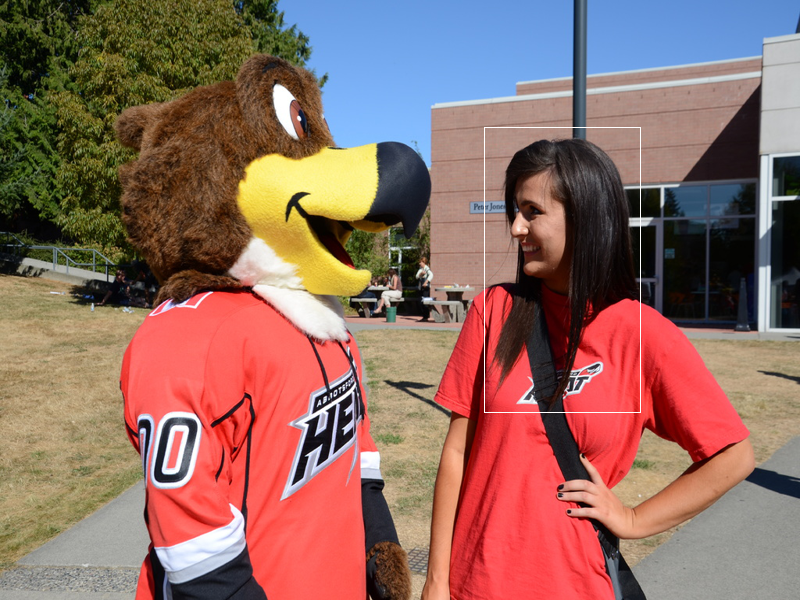

In [44]:
from PIL import Image

with open("full_dataset.csv", "r") as file:
  ds = file.read()

ann_number = 36

l = ds.splitlines()[ann_number-1].split(",")
print(l)
drawbox(Image.open(l[1]).resize((800,600)), [float(i) for i in [l[3],l[4], l[7], l[8]]])

In [45]:
train_data, validation_data, test_data = object_detector.DataLoader.from_csv('full_dataset.csv')

In [46]:
train_data.label_map

{1: 'human_head'}

**Step 3. Train the TensorFlow model with the training data.**

* The EfficientDet-Lite0 model uses `epochs = 50` by default, which means it will go through the training dataset 50 times. You can look at the validation accuracy during training and stop early to avoid overfitting.
* Set `batch_size = 64` here so you will see that it takes 18 steps to go through the 1109 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [48]:
model = object_detector.create(train_data, model_spec=spec, batch_size=64, train_whole_model=True, validation_data=validation_data, epochs=50)

Epoch 1/50
7/7 [==============================] - 58s 4s/step - det_loss: 1.8585 - cls_loss: 1.1176 - box_loss: 0.0148 - reg_l2_loss: 0.0630 - loss: 1.9215 - learning_rate: 0.0427 - gradient_norm: 0.7191 - val_det_loss: 1.5923 - val_cls_loss: 1.0308 - val_box_loss: 0.0112 - val_reg_l2_loss: 0.0630 - val_loss: 1.6552
Epoch 2/50
7/7 [==============================] - 17s 3s/step - det_loss: 1.4700 - cls_loss: 0.8922 - box_loss: 0.0116 - reg_l2_loss: 0.0630 - loss: 1.5330 - learning_rate: 0.0798 - gradient_norm: 1.5886 - val_det_loss: 1.6080 - val_cls_loss: 1.1358 - val_box_loss: 0.0094 - val_reg_l2_loss: 0.0630 - val_loss: 1.6710
Epoch 3/50
7/7 [==============================] - 21s 3s/step - det_loss: 1.1729 - cls_loss: 0.7154 - box_loss: 0.0092 - reg_l2_loss: 0.0630 - loss: 1.2359 - learning_rate: 0.0795 - gradient_norm: 1.5498 - val_det_loss: 1.3128 - val_cls_loss: 0.8951 - val_box_loss: 0.0084 - val_reg_l2_loss: 0.0631 - val_loss: 1.3758
Epoch 4/50
7/7 [==============================

**Step 4. Evaluate the model with the test data.**

After training the object detection model using the images in the training dataset, use the remaining 58 images in the test dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 58 images in the test dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [49]:
model.evaluate(train_data) # let's check how it performs on the training data... just to make sure it learned something

8/8 [==============================] - 26s 2s/step



{'AP': 0.5128722,
 'AP50': 0.74674946,
 'AP75': 0.6047844,
 'APs': 0.00458218,
 'APm': 0.39875573,
 'APl': 0.7735362,
 'ARmax1': 0.32849413,
 'ARmax10': 0.56014425,
 'ARmax100': 0.59900814,
 'ARs': 0.07644231,
 'ARm': 0.54792744,
 'ARl': 0.8468992,
 'AP_/human_head': 0.5128722}

In [50]:
model.evaluate(test_data) # ok, now using the unseen test data!

1/1 [==============================] - 6s 6s/step



{'AP': 0.35299936,
 'AP50': 0.597437,
 'AP75': 0.35497925,
 'APs': 0.0003387181,
 'APm': 0.23274201,
 'APl': 0.45605794,
 'ARmax1': 0.24310344,
 'ARmax10': 0.4413793,
 'ARmax100': 0.5,
 'ARs': 0.05,
 'ARm': 0.42352942,
 'ARl': 0.5837838,
 'AP_/human_head': 0.35299936}

**Step 5.  Export as a TensorFlow Lite model.**

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is full integer quantization.

In [51]:
model.export(export_dir='.') # kind of slow...

**Step 6.  Evaluate the TensorFlow Lite model.**

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [52]:
model.evaluate_tflite('model.tflite', test_data) # the AP dropped a little bit after converting.

33/33 [==============================] - 78s 2s/step



{'AP': 0.34286022,
 'AP50': 0.58660686,
 'AP75': 0.3741445,
 'APs': 0.0,
 'APm': 0.1947177,
 'APl': 0.455682,
 'ARmax1': 0.23965517,
 'ARmax10': 0.42068964,
 'ARmax100': 0.42068964,
 'ARs': 0.0,
 'ARm': 0.28235295,
 'ARl': 0.5297297,
 'AP_/human_head': 0.34286022}

You can download the TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model.tflite` file and choose `Download` to download it to your local computer.

This model can be integrated into an Android or an iOS app using the [ObjectDetector API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) of the [TensorFlow Lite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

See the [TFLite Object Detection sample app](https://github.com/tensorflow/examples/blob/master/lite/examples/object_detection/android/lib_task_api/src/main/java/org/tensorflow/lite/examples/detection/tflite/TFLiteObjectDetectionAPIModel.java#L91) for more details on how the model is used in an working app.

*Note: Android Studio Model Binding does not support object detection yet so please use the TensorFlow Lite Task Library.*

## (Optional) Test the TFLite model on your image

You can test the trained TFLite model using images from the internet.
* Replace the `INPUT_IMAGE_URL` below with your desired input image.
* Adjust the `DETECTION_THRESHOLD` to change the sensitivity of the model. A lower threshold means the model will pickup more objects but there will also be more false detection. Meanwhile, a higher threshold means the model will only pickup objects that it has confidently detected.

Although it requires some of boilerplate code to run the model in Python at this moment, integrating the model into a mobile app only requires a few lines of code.

In [31]:
#@title Load the trained TFLite model and define some visualization functions

import cv2

from PIL import Image

model_path = 'model.tflite'

# Load the labels into a list
classes = ['???'] * model.model_spec.config.num_classes
label_map = model.model_spec.config.label_map
for label_id, label_name in label_map.as_dict().items():
  classes[label_id-1] = label_name

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # # Feed the input image to the model
  # set_input_tensor(interpreter, image)
  # interpreter.invoke()
  # # Get all outputs from the model
  # scores = get_output_tensor(interpreter, 0)
  # boxes = get_output_tensor(interpreter, 1)
  # count = int(get_output_tensor(interpreter, 2))
  # classes = get_output_tensor(interpreter, 3)

  signature_fn = interpreter.get_signature_runner()
  # Feed the input image to the model
  output = signature_fn(images=image.numpy().astype('uint8'))
  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

In [ ]:
# https://image.cnbcfm.com/api/v1/image/106316521-1577799443873art19_2019mayeandkidslaughing.jpg?v=1577799781&w=740&h=416
# https://media.npr.org/assets/img/2019/12/03/ap_080902152760-92f37e95e401b6576ccc475c4e75099faaf13ef7-s800-c85.jpg

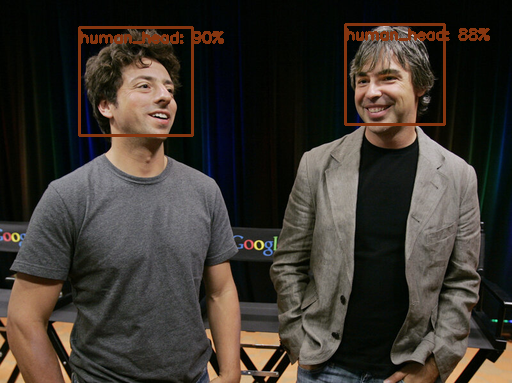

In [53]:
#@title Run object detection and show the detection results on unseen image

INPUT_IMAGE_URL = "https://media.npr.org/assets/img/2019/12/03/ap_080902152760-92f37e95e401b6576ccc475c4e75099faaf13ef7-s800-c85.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE,
    interpreter,
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)

## (Optional) Compile For the Edge TPU

Now that you have a quantized EfficientDet Lite model, it is possible to compile and deploy to a [Coral EdgeTPU](https://coral.ai/).

**Step 1. Install the EdgeTPU Compiler**

In [54]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  79281      0 --:--:-- --:--:-- --:--:-- 79281
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 https://developer.download.nvidia.com/compute/cuda/re

**Step 2. Select number of Edge TPUs, Compile**

The EdgeTPU has 8MB of SRAM for caching model paramaters ([more info](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching)). This means that for models that are larger than 8MB, inference time will be increased in order to transfer over model paramaters. One way to avoid this is [Model Pipelining](https://coral.ai/docs/edgetpu/pipeline/) - splitting the model into segments that can have a dedicated EdgeTPU. This can significantly improve latency.

The below table can be used as a reference for the number of Edge TPUs to use - the larger models will not compile for a single TPU as the intermediate tensors can't fit in on-chip memory.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

In [55]:
NUMBER_OF_TPUS = 1

!edgetpu_compiler -s model.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 2710 ms.

Input model: model.tflite
Input size: 4.24MiB
Output model: model_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: model_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3

Operator                       Count      Status

MAX_POOL_2D                    14       

**Step 3. Download, Run Model**

With the model(s) compiled, they can now be run on EdgeTPU(s) for object detection. First, download the compiled TensorFlow Lite model file using the left sidebar of Colab. Right-click on the `model_edgetpu.tflite` file and choose `Download` to download it to your local computer.

Now you can run the model in your preferred manner. Examples of detection include:
* [pycoral detection](https://github.com/google-coral/pycoral/blob/master/examples/detect_image.py)
* [Basic TFLite detection](https://github.com/google-coral/tflite/tree/master/python/examples/detection)
* [Example Video Detection](https://github.com/google-coral/examples-camera)
* [libcoral C++ API](https://github.com/google-coral/libcoral)


## Advanced Usage

This section covers advanced usage topics like adjusting the model and the training hyperparameters.

### Load the dataset

#### Load your own data

You can upload your own dataset to work through this tutorial. Upload your dataset by using the left sidebar in Colab.

<img src="https://storage.googleapis.com/download.tensorflow.org/models/tflite/screenshots/model_maker_object_detection.png" alt="Upload File" width="1000" hspace="0">

If you prefer not to upload your dataset to the cloud, you can also locally run the library by following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

#### Load your data with a different data format

The Model Maker library also supports the `object_detector.DataLoader.from_pascal_voc` method to load data with [PASCAL VOC](https://towardsdatascience.com/coco-data-format-for-object-detection-a4c5eaf518c5#:~:text=Pascal%20VOC%20is%20an%20XML,for%20training%2C%20testing%20and%20validation) format. [makesense.ai](https://www.makesense.ai/) and [LabelImg](https://github.com/tzutalin/labelImg) are the tools that can annotate the image and save annotations as XML files in PASCAL VOC data format:
```python
object_detector.DataLoader.from_pascal_voc(image_dir, annotations_dir, label_map={1: "person", 2: "notperson"})
```


### Customize the EfficientDet model hyperparameters

The model and training pipline parameters you can adjust are:

* `model_dir`: The location to save the model checkpoint files. If not set, a temporary directory will be used.
* `steps_per_execution`: Number of steps per training execution.
* `moving_average_decay`: Float. The decay to use for maintaining moving averages of the trained parameters.
* `var_freeze_expr`: The regular expression to map the prefix name of variables to be frozen which means remaining the same during training. More specific, use `re.match(var_freeze_expr, variable_name)` in the codebase to map the variables to be frozen.
* `tflite_max_detections`: integer, 25 by default. The max number of output detections in the TFLite model.
* `strategy`:  A string specifying which distribution strategy to use. Accepted values are 'tpu', 'gpus', None. tpu' means to use TPUStrategy. 'gpus' mean to use MirroredStrategy for multi-gpus. If None, use TF default with OneDeviceStrategy.
* `tpu`:  The Cloud TPU to use for training. This should be either the name used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 url.
* `use_xla`: Use XLA even if strategy is not tpu. If strategy is tpu, always use XLA, and this flag has no effect.
* `profile`: Enable profile mode.
* `debug`: Enable debug mode.

Other parameters that can be adjusted is shown in [hparams_config.py](https://github.com/google/automl/blob/df451765d467c5ed78bbdfd632810bc1014b123e/efficientdet/hparams_config.py#L170).


For instance, you can set the `var_freeze_expr='efficientnet'` which freezes the variables with name prefix `efficientnet` (default is `'(efficientnet|fpn_cells|resample_p6)'`). This allows the model to freeze untrainable variables and keep their value the same through training.

```python
spec = model_spec.get('efficientdet-lite0')
spec.config.var_freeze_expr = 'efficientnet'
```

### Change the Model Architecture

You can change the model architecture by changing the `model_spec`. For instance, change the `model_spec` to the EfficientDet-Lite4 model.

```python
spec = model_spec.get('efficientdet-lite4')
```

### Tune the training hyperparameters

The `create` function is the driver function that the Model Maker library uses to create models. The `model_spec` parameter defines the model specification. The `object_detector.EfficientDetSpec` class is currently supported. The `create` function comprises of the following steps:

1. Creates the model for the object detection according to `model_spec`.
2. Trains the model.  The default epochs and the default batch size are set by the `epochs` and `batch_size` variables in the `model_spec` object.
You can also tune the training hyperparameters like `epochs` and `batch_size` that affect the model accuracy. For instance,

*   `epochs`: Integer, 50 by default. More epochs could achieve better accuracy, but may lead to overfitting.
*   `batch_size`: Integer, 64 by default. The number of samples to use in one training step.
*   `train_whole_model`: Boolean, False by default. If true, train the whole model. Otherwise, only train the layers that do not match `var_freeze_expr`.

For example, you can train with less epochs and only the head layer. You can increase the number of epochs for better results.

```python
model = object_detector.create(train_data, model_spec=spec, epochs=10, validation_data=validation_data)
```

### Export to different formats

The export formats can be one or a list of the following:

*   `ExportFormat.TFLITE`
*   `ExportFormat.LABEL`
*   `ExportFormat.SAVED_MODEL`




By default, it exports only the TensorFlow Lite model file containing the model [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file is embedded in metadata.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you quantize the model to make it smaller and potentially run faster. As for EfficientDet-Lite models, full integer quantization  is used to quantize the model by default. Please refer to [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) for more detail.

```python
model.export(export_dir='.')
```

You can also choose to export other files related to the model for better examination. For instance, exporting both the saved model and the label file as follows:
```python
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.LABEL])
```

### Customize Post-training quantization on the TensorFlow Lite model

[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

```python
config = QuantizationConfig.for_float16()
```


Then we export the TensorFlow Lite model with such configuration.

```python
model.export(export_dir='.', tflite_filename='model_fp16.tflite', quantization_config=config)
```

# Read more

You can read our [object detection](https://www.tensorflow.org/lite/examples/object_detection/overview) example to learn technical details. For more information, please refer to:

*   TensorFlow Lite Model Maker [guide](https://www.tensorflow.org/lite/guide/model_maker) and [API reference](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker).
*   Task Library: [ObjectDetector](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for deployment.
*   The end-to-end reference apps: [Android](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/android), [iOS](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/ios), and [Raspberry PI](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

